# Hierarchical Attention Network for Document Classification


# Import libraries


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#import pip
#import theano

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K



[nltk_data] Downloading package punkt to /Users/lanado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lanado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lanado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
# Set the logging level to ERROR to suppress warnings
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Additionally, suppress other warnings if needed
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Functions

In [30]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


def split_df(dataframe, column_name, training_split=0.8, validation_split=0.2):
    """
    Splits a pandas dataframe into training and validation sets in the specified ratio.
    Both sets are balanced, which means they have the same ratio for each category as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.8
             validation_split - from ]0,1[, default = 0.2        
                                Sum of both splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
    """
    if training_split + validation_split != 1.0:
        raise ValueError('Split parameter sum should be 1.0')

    # Shuffle and split the data
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
        .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    validation = dataframe.drop(train.index).sample(frac=1)

    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))

    return train, validation


def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data


def to_categorical(series, n_classes=5):
    """
    Converts numeric category labels to one-hot encoded vectors.
    Input:     series     - pandas Series containing numbered category labels (e.g., 0, 1, 2, 3, 4)
               n_classes  - Number of unique classes (default is 5)
    Output:    Array      - numpy array containing categories converted to one-hot encoded lists
                            e.g. 0 -> [1 0 0 0 0]
                                 1 -> [0 1 0 0 0]
                                 2 -> [0 0 1 0 0]
                                 3 -> [0 0 0 1 0]
                                 4 -> [0 0 0 0 1]
    """
    # Initialize an array of zeros with the shape (number of samples, number of classes)
    y_cat = np.zeros((len(series), n_classes))
    
    # Set the appropriate element to 1
    y_cat[np.arange(len(series)), series] = 1
    
    return y_cat


# Attention layer

In [3]:
class AttentionLayer(Layer):
    """
    Hierarchical Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    TensorFlow backend
    """
    def __init__(self, attention_dim=100, return_coefficients=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        self.attention_dim = attention_dim

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], self.attention_dim),
                                 initializer=self.init,
                                 name='W')
        self.b = self.add_weight(shape=(self.attention_dim,),
                                 initializer=self.init,
                                 name='b')
        self.u = self.add_weight(shape=(self.attention_dim, 1),
                                 initializer=self.init,
                                 name='u')
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs, mask=None):
        hit = inputs
        uit = K.bias_add(K.dot(hit, self.W), self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, axis=-1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]


In [7]:
import pandas as pd

splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [9]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(df.shape[0]):
    sent = tokenize.sent_tokenize(df.loc[i,'text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/df.shape[0]))

Average number of words in each sentence:  18
Average number of sentences in each document:  9


# Parameters

In [10]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

# Data Preprocessing

In [22]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
def clean_articles(dataframe):
    articles = []
    n = dataframe.shape[0]
    col_number = dataframe.columns.get_loc('text')
    stopWords = set(stopwords.words('english'))
    data_cleaned = dataframe.copy()

    for i in range(n):
        temp_string, idx_string = cleanString(df.iloc[i, col_number], stopWords)
        articles.append(temp_string)
        print(str(i+1) + ' of ' + str(n) + " articles cleaned.", end='\r')

    data_cleaned.loc[:, 'text'] = pd.Series(articles, index=dataframe.index)
    return data_cleaned

data_cleaned = clean_articles(df)

In [24]:
data_cleaned.head()

,label,text
0,4,goldberg offer everything look general practit...
1,1,unfortunately frustration goldberg patient rep...
2,3,going goldberg 10 year . think one 1st patient...
3,3,got letter mail last week said goldberg moving...
4,0,know goldberg like moving arizona let tell sta...


# Tokenization

In [25]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
def tokenization(data):
    texts = []
    n = data['text'].shape[0]
    for i in range(n):
        s = data['text'].iloc[i]
        s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
        texts.append(s)
    tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
    tokenizer.fit_on_texts(texts)
    word_index = tokenizer.word_index
    return tokenizer, word_index

tokenizer, word_index = tokenization(data_cleaned)
#val_tokenizer, val_word_index = tokenization(data_cleaned_val)

<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/pn/jrl8dp3x15nfyh50_q0l49km0000gn/T/ipykernel_18837/2588465403.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])


## GloVe Embedding Matrix

In [26]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
def embedding(tokenizer,word_index):
    embeddings_index = {}
    f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'),encoding='UTF-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    # Search words in our word index in the pre-trained dataset
    # Create an embedding matrix for our bbc dataset
    min_wordCount = 0
    absent_words = 0
    small_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    word_counts = tokenizer.word_counts
    for word, i in word_index.items():
        if word_counts[word] > min_wordCount:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
            else:
                absent_words += 1
        else:
            small_words += 1
    print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
        '% of total words')
    print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
        '% of total words')
    return embedding_matrix
    
embedding_matrix = embedding(tokenizer, word_index)
#embedding_matrix_val = embedding(val_tokenizer, val_word_index)

Found 400000 word vectors.
Total absent words are 109041 which is 58.07 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


# Splitting Data Set

In [32]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
#print(categoryToCode)

train, validation= split_df(data_cleaned, 'label',0.8,0.2)
from tensorflow.keras.utils import to_categorical
#Training
paras = []
for i in range(data_cleaned['text'].shape[0]):
    sequence = wordToSeq(df['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
num_classes = 5
y_train = to_categorical(data_cleaned['label'],num_classes)

#Validation
paras = []
for i in range(validation['text'].shape[0]):
    sequence = wordToSeq(validation['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['label'],num_classes)



/var/folders/pn/jrl8dp3x15nfyh50_q0l49km0000gn/T/ipykernel_18837/3605488804.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\


Total:  650000
Training:  520000 , Percentage:  0.8
Validation:  130000 , Percentage:  0.2


In [33]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# HAN MODEL

In [38]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 50)]              0         
                                                                 
 word_embedding (Embedding)  (None, 50, 100)           18777900  
                                                                 
 word_gru (Bidirectional)    (None, 50, 100)           45600     
                                                                 
 word_dense (Dense)          (None, 50, 100)           10100     
                                                                 
 word_attention (AttentionLa  [(None, 100),            10200     
 yer)                         (None, 50, 1)]                     
                                                                 
Total params: 18,843,800
Trainable params: 65,900
Non-trainable params: 18,777,900
_________________________________________

## Train

Epoch 1/7
13000/13000 [==============================] - 3146s 242ms/step - loss: 0.9659 - acc: 0.5791 - val_loss: 0.9003 - val_acc: 0.6042
Epoch 2/7
13000/13000 [==============================] - 3922s 302ms/step - loss: 0.9304 - acc: 0.5961 - val_loss: 0.8788 - val_acc: 0.6156
Epoch 3/7
13000/13000 [==============================] - 6271s 482ms/step - loss: 0.9095 - acc: 0.6058 - val_loss: 0.8758 - val_acc: 0.6174
Epoch 4/7
13000/13000 [==============================] - 3048s 234ms/step - loss: 0.8956 - acc: 0.6113 - val_loss: 0.8602 - val_acc: 0.6243
Epoch 5/7
13000/13000 [==============================] - 6810s 524ms/step - loss: 0.8841 - acc: 0.6163 - val_loss: 0.8563 - val_acc: 0.6251
Epoch 6/7
13000/13000 [==============================] - 4190s 322ms/step - loss: 0.8751 - acc: 0.6203 - val_loss: 0.8617 - val_acc: 0.6245
Epoch 7/7
13000/13000 [==============================] - 7741s 595ms/step - loss: 0.8671 - acc: 0.6234 - val_loss: 0.8654 - val_acc: 0.6203
dict_keys(['loss', '

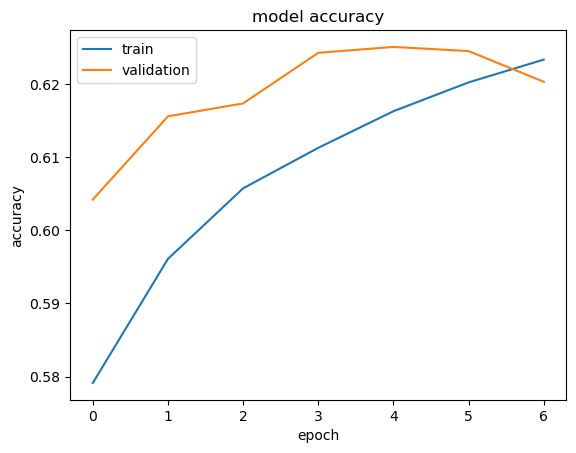

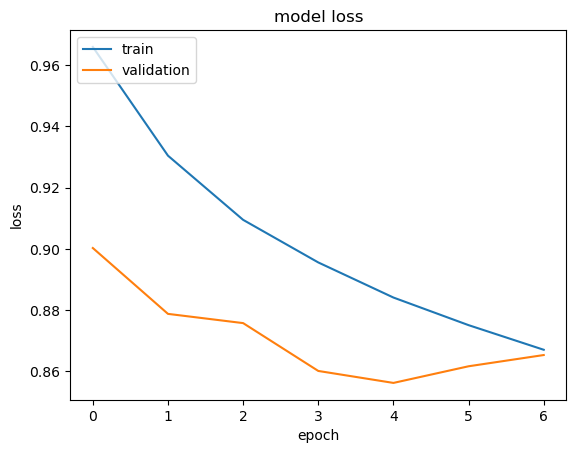

In [43]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=50)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test

## Save Model

In [44]:
# Saves the model in a hdf5 file
model.save('Model_7epoch_yelp.h5')  